In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import ShuffleSplit
from skpsl import ProbabilisticScoringList
from skpsl.metrics import precision_at_recall_k_score
from tqdm import tqdm
from experiment_utils import evaluate_metrics

N_SPLITS = 1
RECALL_CONSTRAINT = 0.9
CALIBRATION_METHOD = "isotonic"

seed = 1
dataset_name = "thorax"

lookaheads = [2]
score_sets = [[-3, -2, -1, 1, 2, 3]]

optimization_metrics = (
    "ee",#"constrained_precision",
    None#lambda y_true, y_prob: -precision_at_recall_k_score(y_true, y_prob, recall_level=RECALL_CONSTRAINT),
)
#optimization_metrics = (
#    "constrained_precision",
#    lambda y_true, y_prob: -precision_at_recall_k_score(y_true, y_prob, recall_level=RECALL_CONSTRAINT),
#)

dataset = pd.read_csv(f"../data/{dataset_name}.csv")

X = dataset.iloc[:, 1:].to_numpy()
y = dataset.iloc[:, 0].to_numpy()

optimization_name, opt_func = optimization_metrics
score_set = score_sets[0]
print(score_set)
stage_clf_params = dict(calibration_method=CALIBRATION_METHOD)
psl = ProbabilisticScoringList(score_set=score_set,
                                stage_loss=opt_func,
                                stage_clf_params=stage_clf_params,
                                lookahead=2)
psl.fit(X,y)

[-3, -2, -1, 1, 2, 3]


ProbabilisticScoringList(lookahead=2, score_set=[-3, -2, -1, 1, 2, 3],
                         stage_clf_params={'calibration_method': 'isotonic'})

In [2]:
from sklearn.metrics import precision_recall_curve
probas_pred = psl.predict_proba(X)[:,1]
precision, recall, thresholds = precision_recall_curve(y,probas_pred)
p,t = precision_at_recall_k_score(y,probas_pred, return_threshold=True)
(precision,recall,thresholds, p,t, len(precision))

(array([0.12789116, 0.13055556, 0.19135802, 0.21647059, 0.30935252,
        0.47169811, 0.65432099, 0.76363636, 0.84615385, 0.9       ,
        1.        , 1.        ]),
 array([1.        , 1.        , 0.9893617 , 0.9787234 , 0.91489362,
        0.79787234, 0.56382979, 0.44680851, 0.23404255, 0.09574468,
        0.0212766 , 0.        ]),
 array([0.        , 0.0042735 , 0.01639344, 0.04081633, 0.09243697,
        0.28205128, 0.42307692, 0.68965517, 0.8125    , 0.875     ,
        1.        ]),
 0.30935251798561153,
 0.09243697478991597,
 12)

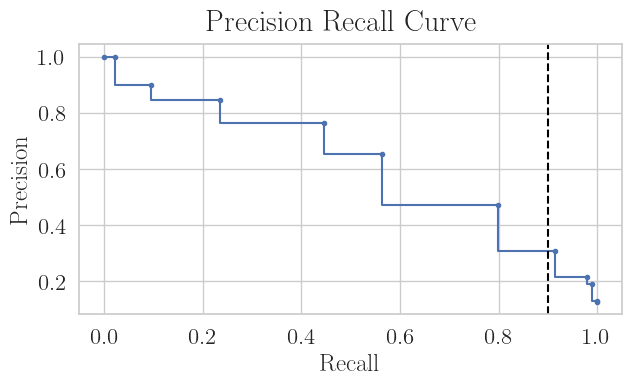

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})

fig,ax = plt.subplots()
fig.set_size_inches(7, 3.5)

ax.scatter(x=recall,y=precision, marker=".")
ax.step(x=recall,y=precision, where="post")
ax.axvline(x=0.9, linestyle="--", color="black")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
#for p,r,t in zip(precision,recall,thresholds):
#    ax.annotate(f"{t:.4f}",(r,p))
fig.suptitle("Precision Recall Curve")
plt.savefig(f"../fig/thorax_precision_recall_curve_thorax_example.pdf", bbox_inches='tight')

In [4]:
psl.inspect()

,Stage,Feature Index,Score,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6,...,T = 12,T = 13,T = 14,T = 15,T = 16,T = 17,T = 18,T = 19,T = 20,T = 21
0,0,NaN,NaN,0.127891,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5.0,3.0,0.070608,NaN,NaN,0.404762,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,8.0,3.0,0.024476,NaN,NaN,0.111717,NaN,NaN,0.560976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4.0,2.0,0.020833,NaN,0.043478,0.078947,NaN,0.269841,0.418182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.0,2.0,0.012987,NaN,0.022222,0.022222,0.071429,0.145161,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0.0,3.0,0.007634,NaN,0.007634,0.007634,0.007634,0.034783,0.034783,...,NaN,0.863636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,7.0,1.0,0.007634,0.007634,0.007634,0.007634,0.007634,0.034783,0.034783,...,0.500000,0.833333,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,9.0,3.0,0.000000,0.000000,0.000000,0.006667,0.006667,0.006667,0.008130,...,0.500000,0.508772,0.508772,0.508772,0.823529,1.000000,NaN,NaN,NaN,NaN
8,8,1.0,1.0,0.000000,0.000000,0.000000,0.004405,0.004405,0.004405,0.004405,...,0.225352,0.470588,0.470588,0.560000,0.750000,0.823529,1.000000,NaN,NaN,NaN
9,9,3.0,1.0,0.000000,0.000000,0.000000,0.004065,0.004065,0.004065,0.004065,...,0.127660,0.338710,0.400000,0.440000,0.666667,0.842105,0.842105,1.000,NaN,NaN
